Install packages

In [1]:
!git clone https://github.com/milesial/Pytorch-UNet.git

fatal: destination path 'Pytorch-UNet' already exists and is not an empty directory.


In [2]:
!ls

data		   interp.db		  Pytorch-UNet	sample_data
data-faultseg.zip  model_epoch_00000.pth  S1.jpg


In [3]:
import sys
from pathlib import Path
unet_path = 'Pytorch-UNet/'
sys.path.append(unet_path)

In [4]:
import unet

Download seismic and interpretations:

In [5]:
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt

from unet import UNet
# from utils import l2_regularisation
from tqdm.auto import tqdm, trange

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

Overall parametrization

In [6]:
lr = 1e-5
epochs = 100
save_every_steps = 5
save_every_epoch = 50
batch_size = 16

# Architecture parameters:
n_channels = 1
n_classes = 1
n_nets = 5

This is Xinming Wu's keras dataloader:

In [7]:
import os
class MyDataset(Dataset):
    def __init__(self, dpath,fpath, dim = (128, 128, 128)):
        self.dpath = dpath
        self.fpath = fpath
        self.dim = dim
        dpath_files = os.listdir(dpath)
        fpath_files = os.listdir(fpath)
        assert dpath_files == fpath_files
        self.volumes = []
        for fname in dpath_files:
            d = np.fromfile(os.path.join(self.dpath, fname),dtype=np.single)
            f = np.fromfile(os.path.join(self.fpath, fname),dtype=np.single)
            d = d.reshape(1, *dim)
            f = f.reshape(1, *dim)
            self.volumes.append([d, f])
    def __len__(self):
        return len(self.volumes)
    def __getitem__(self, i):
        x, y = self.volumes[i]
        iln = np.random.choice(self.dim[0])
        x = x[:, iln]
        y = y[:, iln]
        return x, y

In [8]:
# import os
# class MyDataset(Dataset):
#     def __init__(self, dpath,fpath, dim = (128, 128, 128)):
#         self.dpath = dpath
#         self.fpath = fpath
#         self.dim = dim
#         dpath_files = os.listdir(dpath)
#         fpath_files = os.listdir(fpath)
#         assert dpath_files == fpath_files
#         self.dpath_files = dpath_files
#     def __len__(self):
#         return len(self.dpath_files)
#     def __getitem__(self, i):
#         fname = self.dpath_files[i]
#         d = np.fromfile(os.path.join(self.dpath, fname),dtype=np.single)
#         f = np.fromfile(os.path.join(self.fpath, fname),dtype=np.single)
#         x = d.reshape(1, *self.dim)
#         y = f.reshape(1, *self.dim)
#         iln = np.random.choice(self.dim[0])
#         x = x[:, iln]
#         y = y[:, iln]
#         return x, y

In [9]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='133XNGEsOPEqU9JNaCIfslN2LfnhTeLDD',
                                    dest_path='/content/data-faultseg.zip',
                                    unzip=True)

In [10]:
!unzip "./data/train/fault.zip" -d "data/train/"

Archive:  ./data/train/fault.zip
replace data/train/fault/58.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
seismPathT = Path("./data/train/seis/")
faultPathT = Path("./data/train/fault/")

seismPathV = Path("./data/validation/seis/")
faultPathV = Path("./data/validation/fault/")

train_generator = MyDataset(dpath=seismPathT,fpath=faultPathT)
valid_generator = MyDataset(dpath=seismPathV,fpath=faultPathV)

In [12]:
x, y = train_generator[0]
x.shape

(1, 128, 128)

In [13]:
train_loader = DataLoader(train_generator, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(valid_generator, batch_size = batch_size, shuffle = True)

In [14]:
x, y = next(iter(train_loader))
x.shape

torch.Size([16, 1, 128, 128])

Now I try to load it with the pytorch dataloader:

In [15]:
torch.cuda.is_available()

True

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is', device)

device is cuda


In [17]:
class Logger(object):
    def __init__(self):
        self.metrics = ['mse_loss', 'std']
        self.lists = [[], []]
        self.steps = []
    def step(self, global_step, *args):
        for i, value in enumerate(args):
            self.lists[i].append(value.item())
        self.steps.append(global_step)

Here we need to adjust the dimensions:

In [18]:
class DeepEnsemble(nn.Module):
    def __init__(self, n_channels = 1, n_classes = 1, n_nets = 5):
        super(DeepEnsemble, self).__init__()
        self.n_nets = n_nets
        self.n_channels = n_channels
        self.n_classes = n_classes
        mod_list = [UNet(n_channels=n_channels, n_classes=n_classes) for _ in range(n_nets)]
        self.nets = nn.ModuleList(mod_list)
    def forward(self, x, i):
        return self.nets[i](x)
    def forward_reduce(self, x):
        with torch.no_grad():
            pred_ = [net(x).unsqueeze(0) for net in self.nets]
            pred = torch.cat(pred_, dim=0)
            return pred.mean(0), pred.std(0)

In [19]:
model = DeepEnsemble(n_channels=n_channels,
                     n_classes=n_classes, 
                     n_nets=n_nets)

model = model.to(device)

In [20]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
with torch.no_grad():
    print('ypred shape', model(x,0).shape)
    print('ypred mean shape', model.forward_reduce(x)[0].shape)
    print('y shape', y.shape)

ypred shape torch.Size([16, 1, 128, 128])
ypred mean shape torch.Size([16, 1, 128, 128])
y shape torch.Size([16, 1, 128, 128])


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
global_step = 0
nsamples = 64
loss_fn = nn.MSELoss()
logger = Logger()
loggerVal = Logger()

def compute_stats(mask, pred):
    var_pred = pred.var(0)
    loss = loss_fn(mask, pred).detach()
    std = var_pred.mean()**0.5
    return loss, std

for epoch in trange(epochs, desc = 'epochs'):
    for step in trange(len(train_loader), desc='batches', leave=False):
        patch, mask = next(iter(train_loader))
        patch = patch.to(device)
        mask = mask.to(device)
        i = torch.randint(n_nets, (1,)).item()
        pred = model(patch, i)
        loss = loss_fn(mask, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if global_step % save_every_steps == 0:
            with torch.no_grad():
                mse, std = compute_stats(mask, pred.detach())
                logger.step(global_step, mse, std)

                patch, mask = next(iter(val_loader))
                patch = patch.to(device)
                mask = mask.to(device)
                pred = model(patch, i).detach()
                mse, std = compute_stats(mask, pred.detach()
                                        )
                loggerVal.step(global_step, mse, std)
        global_step += 1
    if epoch % save_every_epoch==0:
        torch.save(model.state_dict(), f'model_epoch_{epoch:05d}.pth')
torch.save(model.state_dict(), f'model_epoch_{epoch:05d}.pth')

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [22]:
len(logger.lists[0])

260

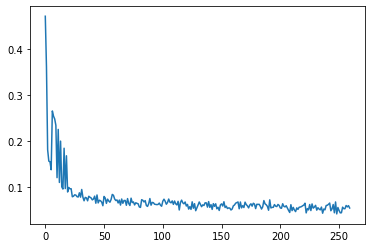

In [23]:
plt.plot(logger.lists[0])

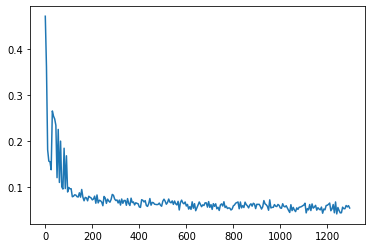

In [24]:
plt.plot(logger.steps, logger.lists[0], label = logger.metrics[0])

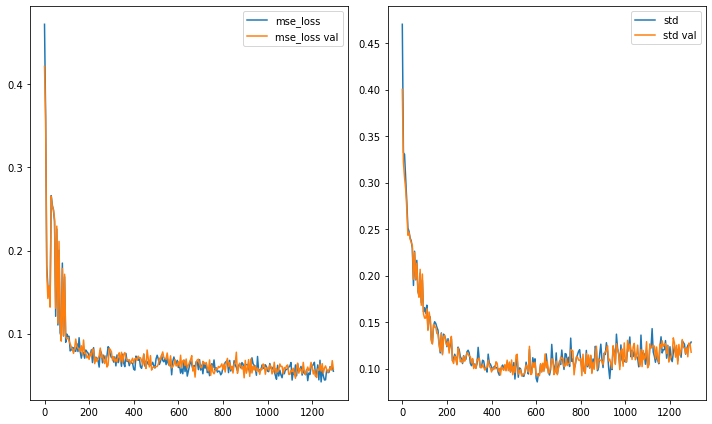

In [25]:
ncols = 2
nrows = len(logger.metrics) // ncols
fig, axs = plt.subplots(figsize = (10, 6), ncols = ncols, nrows = nrows)
for i, name in enumerate(logger.metrics):
    axs.flatten()[i].plot(logger.steps, logger.lists[i], label = name)
    axs.flatten()[i].plot(loggerVal.steps, loggerVal.lists[i], label = name+' val')
    if name in ['kl divergence', 'reconstruction_loss']:
        axs.flatten()[i].set_yscale('log')
    axs.flatten()[i].legend()
plt.tight_layout()

In [27]:
patch, mask = next(iter(train_loader))

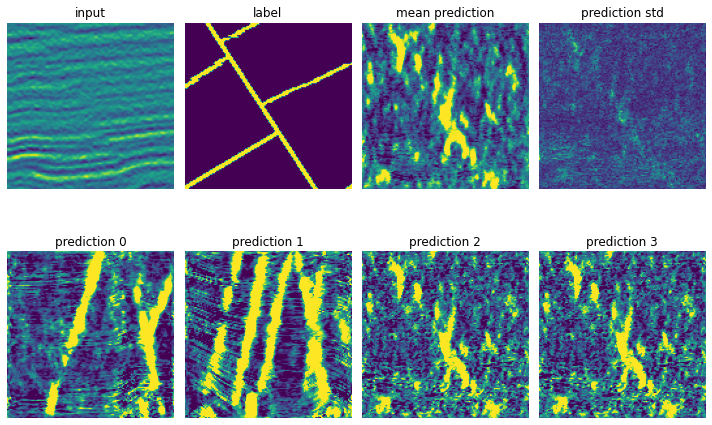

In [33]:


nsamples = 4
ncols = 4
nrows = int(np.ceil((nsamples+3) / ncols))

mean_pred, std_pred = model.forward_reduce(patch.to(device))

vmin = torch.quantile(pred_mask, 0.1)
vmax = torch.quantile(pred_mask, 0.9)

fig, axs = plt.subplots(figsize = (10, 7), ncols = ncols, nrows = nrows)
axs.flatten()[0].imshow(patch[i,0].T)
axs.flatten()[0].axis('off')
axs.flatten()[0].set_title('input')
axs.flatten()[1].imshow(mask[i,0].T)
axs.flatten()[1].axis('off')
axs.flatten()[1].set_title('label')

for j in range(nsamples):
    i = np.random.randint(n_nets)
    pred_mask = model(patch.to(device), i).detach().cpu()
    axs.flatten()[j+4].imshow(pred_mask[i,0].T, vmin = vmin, vmax = vmax)
    axs.flatten()[j+4].axis('off')
    axs.flatten()[j+4].set_title(f'prediction {j:d}')


axs.flatten()[2].imshow(mean_pred[i,0].cpu().T, vmin = vmin, vmax = vmax)
axs.flatten()[2].axis('off')
axs.flatten()[2].set_title(f'mean prediction')

axs.flatten()[3].imshow(std_pred[i,0].cpu().T)
axs.flatten()[3].axis('off')
axs.flatten()[3].set_title(f'prediction std')

plt.tight_layout()